In [247]:
import os
import tensorflow as tf
import numpy as np
import matplotlib
import pandas as pd
matplotlib.use('agg')
import matplotlib.pyplot as plt 
import random
import re
import csv
import glob

import multiprocessing

from sklearn import model_selection

In [248]:
from stop_words import get_stop_words

## Parameters Setup

In [250]:
ROOT_PATH='/home/denocris/Desktop/NeuralTagger/dnn_train'

# select the ambiguity
AMB='ha_a'

# POS & PLACEHOLDER in NT-v1-POS is automatically done in the main tf code
# If you are using NT-v1 set SUB_PLACEHOLDER to True
POS_DATASET = False
SUB_PLACEHOLDER  = True

# version of the dataset
# nph: non-placeholder (it is added directly in the main tf code)
VERSION='v48.tsv'


case = AMB.split('_')

amb1, amb2 = case[0], case[1]

amb1, amb2

('ha', 'a')

### Counting Class Elements

In [251]:
#! wc -l /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e/ver/*
class1_num = !wc -l ./amb_raw/$AMB/$amb1/* | tail -n 1
#! wc -l /home/asr/prj_SlotTagger/dnn_train/amb_raw/è_e/cong/*
class2_num = !wc -l ./amb_raw/$AMB/$amb2/* | tail -n 1

class1_num = class1_num[0].strip().split()
class2_num = class2_num[0].strip().split()

ratio = int(class1_num[0]) / float(class2_num[0]) if int(class1_num[0]) < int(class2_num[0]) else int(class2_num[0]) / float(class1_num[0])

print('Class1: %d, Class2: %d, Ratio: %.3f' %(int(class1_num[0]), int(class2_num[0]), ratio)) 

Class1: 397233, Class2: 395916, Ratio: 0.997


#### Compute ratio for future class balancing

In [252]:
ratio = int(class1_num[0]) / float(class2_num[0]) if int(class1_num[0]) < int(class2_num[0]) else int(class2_num[0]) / float(class1_num[0])

ratio

0.9966845654817198

### Inverting ambiguities

The largest class must be the 2nd one (for the code to work properly). SO if class 1 is larger, than invert them

In [253]:
if int(class1_num[0]) >= int(class2_num[0]):
    amb2, amb1 = case[0], case[1]   
    print('Inverted -->', (amb1, amb2))

Inverted --> ('a', 'ha')


## Ad-hoc Sentences

Sentences generated by grammars or hand-written 

In [254]:
class1_adhoc = []
class2_adhoc  = []

for name in glob.glob(r'./adhocsents/'+AMB+'/*'):
    print(name)
    file = open(name, "r")
    if name.split('/')[-1].split('_')[0]==amb1:
        adhoc1_tmp = [ line.rstrip().lower() for line in file ]
        class1_adhoc += adhoc1_tmp
    elif name.split('/')[-1].split('_')[0]==amb2:
        adhoc2_tmp = [ line.rstrip().lower() for line in file ]
        class2_adhoc += adhoc2_tmp
        
adhoc_dict = {amb1: class1_adhoc, amb2: class2_adhoc}

print('Ex of an dhoc sentence from ambiguity %s: %s' %(amb1, np.random.choice(class1_adhoc).strip()))
print('Ex of an dhoc sentence from ambiguity %s: %s' %(amb2, np.random.choice(class2_adhoc).strip()))

./adhocsents/ha_a/a_adhoc.txt
./adhocsents/ha_a/ha_adhoc_byhand.txt
./adhocsents/ha_a/a_adhoc_byhand.txt
./adhocsents/ha_a/chiama_a.txt
./adhocsents/ha_a/ha_adhoc.txt
Ex of an dhoc sentence from ambiguity a: traducimi questo testo da italiano a portoghese
Ex of an dhoc sentence from ambiguity ha: che età ha kycgw


## Building the Data-Frame (Balanced)

In [255]:
def load_dataset(directory_1, directory_2):
    # NOTE: Put in directory_2 the largest corpus
    data = {}
    data["sentence"] = []
    data["class"] = []
    l1 = 0
    
    class1num = ! cat $directory_1/* | wc -l
    class2num = ! cat $directory_2/* | wc -l

    assert int(class2num[0]) >= int(class1num[0])
    
    #Append ad-hoc sentences
    for s in adhoc_dict[amb1]:
        s = s.strip()
        data["sentence"].append(s)
        data["class"].append(1)
        
        
    for s in adhoc_dict[amb2]:
        s = s.strip()
        data["sentence"].append(s)
        data["class"].append(0)
        
    for file_path in os.listdir(directory_1):
        with tf.gfile.GFile(os.path.join(directory_1 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines()]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(1)
    
    for file_path in os.listdir(directory_2):
        with tf.gfile.GFile(os.path.join(directory_2 , file_path), "rb") as f:
                # strip() removes white spaces before and after the string
                # decode() converst a byte object ('b) in a python3 string
                list_of_sentences = [s.strip().decode() for s in f.readlines() if np.random.random() <= ratio]
                num_rows_1 = len(list_of_sentences)
                for i in range(num_rows_1):
                    data["sentence"].append(list_of_sentences[i])
                    data["class"].append(0)

    return pd.DataFrame.from_dict(data)


In [256]:
%%time
directory_1 = ROOT_PATH + '/amb_raw/'+AMB+'/'+amb1+'/'
directory_2 = ROOT_PATH + '/amb_raw/'+AMB+'/'+amb2+'/'

# NOTE: Put in directory_2 the largest class
dataset_df = load_dataset(directory_1, directory_2)

CPU times: user 9.3 s, sys: 336 ms, total: 9.64 s
Wall time: 10 s


In [257]:
# Check Balanced
print('If classes are not perfectly balaced, do not worry! We added non balanced adhoc sentences...')
dataset_df.groupby('class').count()


If classes are not perfectly balaced, do not worry! We added non balanced adhoc sentences...


,sentence
class,
0,398342
1,404063


In [258]:
# Print some samples
for i in range(6):
    print(dataset_df.iloc[i]['sentence'])
    print(dataset_df.iloc[-i -1]['sentence'])

bixby ristoranti a udine
quanta ram ha il mio telefono
centri commerciali a civitavecchia
che sintomi ha l epatite
eventi a budapest
quanta ram ha il mio computer
sciopero a sydney
quanta memoria ha il mio computer
pioggia a l aquila
quanta ram ha il mio cellulare
bixby aperitivo a l aquila
quanta memoria ha il mio cellulare


### Remove puntuations and spaces

In [259]:
exclude1 = ['\t', '"', '?', '!','-', '_'] # list
exclude2 = ["'", "  ", "   ", "    ", "     "] # list

def clean_text(text):
    for c in exclude1:
        text=text.replace(c,'')
    for c in exclude2:
        text=text.replace(c, " ")
        
    text = re.sub(r'\bbè\b', 'è', text)
    text = re.sub(r'\bèb\b', 'è', text)
    text = re.sub(r'\bbdove\b', 'dove', text)
    text = re.sub(r'\bbcome\b', 'come', text)
    text = re.sub(r'\bbquale\b', 'quale', text)
    text = re.sub(r'\bbquando\b', 'quando', text)
    text = re.sub(r'\bbquanto\b', 'quanto', text)
    text = re.sub(r'ã', 'à', text)

    return text.lower().strip()

sentence_processed = list(map(lambda x: clean_text(x), dataset_df['sentence'].values))

dataset_df['sentence'] = sentence_processed

#dataset_df.head(10)

### HO_O only!

In [220]:
cut_off = .5 #percentage to remove

if AMB=='ho_o':

    # create a column which entries are random numbers between 0 and 1
    dataset_df['random'] = [np.random.random() for i in range(len(dataset_df))] 

    # select rows whose sentence do NOT starts with 'o '
    df_notstartswith_o = dataset_df[~(dataset_df["sentence"].str.startswith('o '))]

    # select 50% of rows whose sentence starts with 'o '
    df_startswith_o_50 = dataset_df[((dataset_df["sentence"].str.startswith('o ')) & (dataset_df["random"] <= cut_off))]
    
    # concat the two dataframe
    dataset_df = pd.concat([df_notstartswith_o, df_startswith_o_50], ignore_index=True)
    # remove 'random' column
    dataset_df = dataset_df.drop(columns=['random'])


    print(len(df_notstartswith_o), len(df_startswith_o_50), len(dataset_df))
    assert len(df_notstartswith_o)+len(df_startswith_o_50)==len(dataset_df)


### Hanno_anno only!

In [221]:
cut_off = .75 #percentage to remove

if AMB=='hanno_anno':

    # create a column which entries are random numbers between 0 and 1
    dataset_df['random'] = [np.random.random() for i in range(len(dataset_df))] 

    # select rows whose sentence do NOT starts with 'o '
    df_notcontains_chehanno = dataset_df[~(dataset_df["sentence"].str.contains("che hanno"))]

    # select 50% of rows whose sentence starts with 'o '
    df_contains_chehanno = dataset_df[((dataset_df["sentence"].str.contains("che hanno")) & (dataset_df["random"] <= cut_off))]
    
    # concat the two dataframe
    dataset_df = pd.concat([df_notcontains_chehanno, df_contains_chehanno], ignore_index=True)
    # remove 'random' column
    dataset_df = dataset_df.drop(columns=['random'])


    print(len(df_notcontains_chehanno), len(df_contains_chehanno), len(dataset_df))
    assert len(df_notcontains_chehanno)+len(df_contains_chehanno)==len(dataset_df)

### Shuffle the Dataset

In [260]:
index = [i for i in range(dataset_df.shape[0])]
random.shuffle(index)
dataset_df = dataset_df.set_index([index]).sort_index()

dataset_df.head(10)

,class,sentence
0,0,cosa è ti ha preso per scemo
1,1,a me piacciono ie tue riviste sporcaccione
2,0,come namor personaggio della marvel comics ha ...
3,1,spero che tu capisca che potresti esserci util...
4,1,non hai nessuna possibilità contro loki fino a...
5,0,ha cambiato idea
6,1,che tempo fa lunedì a il cairo
7,1,henry e io vi abbiamo cercato più a lungo ma a...
8,1,o fanne a meno
9,1,e a quel punto sono stata meglio


In [263]:
tot_sample = len(dataset_df)
print('Total samples: ', tot_sample)

Total samples:  802405


#### Reduce the Dataset

In [264]:
num_sample = len(dataset_df) #400000

dataset_red = dataset_df.head(num_sample)

dataset_pos = dataset_red.copy()


assert id(dataset_red) != id(dataset_pos)

### Statistics about the dataset

This cell is just for statistics. It is not mandatory to run it!

In [117]:
# Counting number of words and mean
dataset_red.astype('str').applymap(lambda x: str(x).count(' ') + 1).mean()

class       1.000000
sentence    7.628967
dtype: float64

In [118]:
# Max length sentence
dataset_red.astype('str').applymap(lambda x: str(x).count(' ') + 1).max()

class        1
sentence    13
dtype: int64

In [119]:
# Max length sentence
dataset_red.astype('str').applymap(lambda x: str(x).count(' ') + 1).std()

class       0.000000
sentence    2.823671
dtype: float64

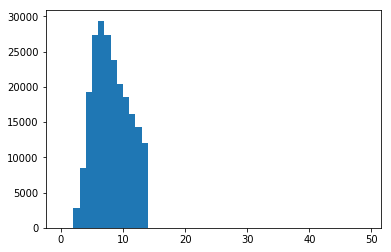

In [120]:
# Histogram of the lengths
%matplotlib inline

length_sentence = dataset_red.astype('str').applymap(lambda x: str(x).count(' ') + 1)
plt.hist(length_sentence['sentence'],bins=range(50))
plt.show()

### Substitute ambiguities with a placeholder (tannutuva)

it works if SUB_PLACEHOLDER = True

In [265]:
toSubstitute = case # list

# def substitute_amniguity_old(text, placeholder):
#     for c in toSubstitute:
#         text=text.replace(c,placeholder)
#     return text.lower().strip()

def substitute_amniguity(text, placeholder):
    for c in toSubstitute:
        text=re.sub(r"\b%s\b" %(c),placeholder, text)
    return text.lower().strip()

placeholder = 'tannutuva'
res = 'A placeholder has NOT been inserted! This is fine if your main tf code does it automatically.'
if SUB_PLACEHOLDER:
    res = 'A placeholder has been inserted: it is '+placeholder
    sentence_processed = list(map(lambda text: substitute_amniguity(text,placeholder), dataset_red['sentence'].values))
    dataset_red['sentence'] = sentence_processed

print(res)
dataset_red.head(10)

A placeholder has been inserted: it is tannutuva


,class,sentence
0,0,cosa è ti tannutuva preso per scemo
1,1,tannutuva me piacciono ie tue riviste sporcacc...
2,0,come namor personaggio della marvel comics tan...
3,1,spero che tu capisca che potresti esserci util...
4,1,non hai nessuna possibilità contro loki fino t...
5,0,tannutuva cambiato idea
6,1,che tempo fa lunedì tannutuva il cairo
7,1,henry e io vi abbiamo cercato più tannutuva lu...
8,1,o fanne tannutuva meno
9,1,e tannutuva quel punto sono stata meglio


### Split for Tagger Classifier (Train, Valid)

In [266]:

splitter =  model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.1,random_state=19850610)

splits = list(splitter.split(X=dataset_red['sentence'], y=dataset_red['class']))
train_index = splits[0][0]
valid_index = splits[0][1]

train_df = dataset_red.loc[train_index,:]
print('Training-Set size: %d' %len(train_df))

valid_df = dataset_red.loc[valid_index,:]
print('Validation-Set size: %d' %len(valid_df))

Training-Set size: 722164
Validation-Set size: 80241


In [267]:
validation_value_counts = valid_df['class'].value_counts()
validation_value_counts[1]

40407

In [268]:
print("Training Set")
training_value_counts = train_df['class'].value_counts()
print(training_value_counts)
print("class 0 %: {}".format(round(training_value_counts[0]/len(train_df)*100,2)))
print("class 1 %: {}".format(round(training_value_counts[1]/len(train_df)*100,2)))
print("")
print("Validation Set")
validation_value_counts = valid_df['class'].value_counts()
print(validation_value_counts)
print("class 0 %: {}".format(round(validation_value_counts[0]/len(valid_df)*100,2)))
print("class 1 %: {}".format(round(validation_value_counts[1]/len(valid_df)*100,2)))

Training Set
1    363656
0    358508
Name: class, dtype: int64
class 0 %: 49.64
class 1 %: 50.36

Validation Set
1    40407
0    39834
Name: class, dtype: int64
class 0 %: 49.64
class 1 %: 50.36


In [269]:
#VERSION='nph_100k'

In [270]:
train_df.to_csv(os.path.join(ROOT_PATH, 'datasets/'+AMB+'/train_data_'+VERSION), header=False, index=False, sep='\t')
valid_df.to_csv(os.path.join(ROOT_PATH, 'datasets/'+AMB+'/valid_data_'+VERSION), header=False, index=False, sep='\t')

print('train is saved: ', 'datasets/'+AMB+'/train_data_'+VERSION)
print('valid is saved: ', 'datasets/'+AMB+'/valid_data_'+VERSION)

train is saved:  datasets/ha_a/train_data_v48.tsv
valid is saved:  datasets/ha_a/valid_data_v48.tsv


## Calculate Vocabulary and Save it

In [271]:
if not POS_DATASET:
    dataset_pos = dataset_red
    
dataset_red.head(5)

,class,sentence
0,0,cosa è ti tannutuva preso per scemo
1,1,tannutuva me piacciono ie tue riviste sporcacc...
2,0,come namor personaggio della marvel comics tan...
3,1,spero che tu capisca che potresti esserci util...
4,1,non hai nessuna possibilità contro loki fino t...


In [272]:
from itertools import chain

# def get_vocab(df):
#     vocab = set()
#     for text in df['sentence'].values:
#         words = text.split(' ')
#         # remove digits
#         words_only = [w for w in words if not w.isdigit()]
#         # exclude words shorter than 2, but not numbers. exclude words with numbers inside, i.e. '3cris', 'c45ris', 'cris23'
#         words_ = [w for w in words_only if len(w) > 0 ]
#         word_set = set(words_)
#         vocab.update(word_set)
    
#     return list(vocab)

def get_all_words(df):
    allWords = [text.split(' ') for text in df['sentence'].values]
    allWords = list(chain(*allWords))
    allWords = [w for w in allWords if not w.isdigit()]
    allWords = [w for w in allWords if len(w) > 0 ]
    return allWords

In [273]:
%%time
# vocab = get_vocab(dataset_pos)
# print('--------------------', len(vocab))

allWords = get_all_words(dataset_pos)
print('--------------------', len(allWords))

vocab = set(allWords)

-------------------- 6564461
CPU times: user 12.8 s, sys: 1.12 s, total: 13.9 s
Wall time: 15.4 s


In [274]:
from collections import Counter
cnt_allWords = Counter(allWords)

vocab_words_sorted_by_appearence = sorted(cnt_allWords.items(), key=lambda kv: len(vocab) - kv[1])
#vocab_words_sorted_by_appearence

vocab_words_sorted_by_appearence_list = [word[0] for word in vocab_words_sorted_by_appearence]
#vocab_words_sorted_by_appearence_list, len(vocab_words_sorted_by_appearence_list)

In [275]:
STOP_WORDS = False
REDUCED_SIZE_VOC = True
SIZE_VOC = 15000

vocab = vocab_words_sorted_by_appearence_list


if STOP_WORDS:
    stop_words = get_stop_words('italian') 
    vocab = [w for w in vocab if w not in stop_words]
    words_and_frequence = [ (word, freq) for (word, freq) in vocab_words_sorted_by_appearence if word not in stop_words]

init_len = len(vocab)
if REDUCED_SIZE_VOC:
    vocab = vocab[0:SIZE_VOC]
    
print("The initial vocabulary of ", init_len, " has been reduced to the most frequent ", len(vocab), " words")


The initial vocabulary of  142399  has been reduced to the most frequent  15000  words


In [276]:
'propn' in vocab

False

#### Adding to the vocabulary relevant words

In [277]:
# PROPN must be added to the vocabulary. Now is not present, but in the main code lots of proper names are going 
# to be pos-tagged with PROPN

#adhoc_words = ['propn','tannutuva']
adhoc_words = ['tannutuva']

for word in adhoc_words:
    if word in vocab:
        continue
    else:
        vocab.append(word)
    
vocab = set(vocab)    
print("Now the number of words is: ", len(vocab))

Now the number of words is:  15000


#### Remove from the vocabulary the ambiguities

In [278]:
if not SUB_PLACEHOLDER:
    vocab.remove(amb1)
    vocab.remove(amb2)

amb1 in vocab, amb2 in vocab

(False, False)

In [279]:
'propn' in vocab, 'tannutuva' in vocab

(False, True)

#### Define some paths

In [280]:
sizevoc = str(int(SIZE_VOC/1000))+'k'

PATH_VOCAB = 'datasets/'+AMB+'/vocab_'+sizevoc+'_'+VERSION
tmp_PATH_VOCAB = re.sub("vocab",'tmp_vocab', PATH_VOCAB )
PATH_NWORDS = re.sub("vocab",'n_words', PATH_VOCAB )

In [281]:
tmp_PATH_VOCAB 
#! ls datasets/sarà_sara/

'datasets/ha_a/tmp_vocab_15k_v48.tsv'

In [282]:
ROOT_PATH ='./'# +tmp_PATH_VOCAB

In [283]:
tmp_PATH_VOCAB

'datasets/ha_a/tmp_vocab_15k_v48.tsv'

In [284]:
PAD_WORD = '#=KS=#'

PATH_VOC = os.path.join(ROOT_PATH, tmp_PATH_VOCAB)
with open(PATH_VOC , 'w') as file:
    file.write("{}\n".format(PAD_WORD))
    for word in vocab:
        file.write("{}\n".format(word))


! awk '! /^[0-9]+$/' ./$tmp_PATH_VOCAB |  sed '/^$/d'  > ./$PATH_VOCAB
#! rm -rf ./$tmp_PATH_VOCAB

print('vacab is saved: ', PATH_VOCAB)

vacab is saved:  datasets/ha_a/vocab_15k_v48.tsv


In [285]:
!$PATH_VOCAB

/bin/sh: 1: datasets/ha_a/vocab_15k_v48.tsv: Permission denied


#### Save the exact number of words in the vocabulary

In [286]:
#! sed 's/[^a-zA-Z]//g' /home/asr/prj_SlotTagger/dnn_train/datasets/è_e/vocab_15k_swin_v13_tmp.tsv | awk '! /^[0-9]+$/' | sed '/^$/d' > /home/asr/prj_SlotTagger/dnn_train/datasets/è_e/vocab_15k_swin_v13.tsv 
nwords=! wc -l ./$PATH_VOCAB
nwords=nwords[0].strip().split()[0]
print(nwords)

PATH_WORDS = os.path.join(ROOT_PATH, PATH_NWORDS)        
with open(PATH_WORDS, 'w') as file:
#with open('/home/asr/Data/classif_task/jsgf_data/n_words.tsv', 'w') as file:
    file.write(str(nwords))
    
print('n_words is saved: ', PATH_WORDS)

15001
n_words is saved:  ./datasets/ha_a/n_words_15k_v48.tsv


In [148]:
!gawk -i inplace -F '\t' '{ print $2 "\t" $1}' valid_data_v12.tsv
!gawk -i inplace -F '\t' '{ print $2 "\t" $1}' train_data_v12.tsv

gawk: inplace:14: warning: inplace_begin: Cannot stat `valid_data_v12.tsv' (No such file or directory)
gawk: inplace:14: fatal: cannot open file `valid_data_v12.tsv' for reading (No such file or directory)
gawk: inplace:14: warning: inplace_begin: Cannot stat `train_data_v12.tsv' (No such file or directory)
gawk: inplace:14: fatal: cannot open file `train_data_v12.tsv' for reading (No such file or directory)
